<a href="https://colab.research.google.com/github/sundaysvnset/Final-Project-Pengolahan-Sinyal-Group-1-/blob/main/PSB_FinalProject_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# **Breast Cancer Severity Classification and Subtype Prediction from Mammographic Images for Treatment Recommendation**  

**Group 1 | Pengolahan Sinyal Biomedis**  

Rufaida Kariemah (2206031561)  
Annisa Rahmah (2206032412)  
Shofiyah (2206060662)  

</div>

---

## **Tentang Projek**  
*Kanker payudara menyumbang ~25% kasus kanker baru pada perempuan global (WHO, 2023). Proyek ini mengembangkan sistem cascaded deep learning berbasis EfficientNet B0 untuk:*  
1. **Klasifikasi Keparahan**: Menggunakan dataset INbreast (410 citra DICOM) dengan skor BI-RADS  
2. **Prediksi Subtipe Molekuler**: Menggunakan subset CMMD2 (2,956 citra) dengan 4 subtipe  
3. **Rekomendasi Terapi**: Pemetaan subtipe ke pedoman klinis NCCN 2023  

---

## **Dataset yang digunakan**
**A. INbreast Dataset**
- Jenis: Dataset mammografi digital full-field (FFDM)
- Jumlah kasus: 115 kasus (89 pasien)
- Jumlah gambar: 410 citra (format DICOM (.dcm))

**Isi/Label:**

- Anotasi BI-RADS score (0 sampai 5)
- Anotasi klasifikasi lesi: normal, jinak (benign), ganas (malignant)
- Informasi tambahan: jenis lesi (massa, mikrokalsifikasi, asimetri, distorsi arsitektur, dll)
- Anotasi lesi berbentuk maske segmenasi (jika digunakan, dalam format XML dari software Mammo Viewer)

Tujuan dalam proyek: Klasifikasi tahap awal (apakah kanker dan tingkat keparahannya)

**B. CMMD (Chinese Mammography Database)**
- Versi digunakan: CMMD2
- Jumlah citra: 2,956 citra (dari 1,177 pasien)
- Jenis: Citra mammografi 2D (format DICOM)

**Isi/Label:**

- Informasi diagnosis histopatologi
- Subtipe molekuler kanker:
- Luminal A
- Luminal B
- HER2-positive
- Triple-negative
- Metadata pasien: usia, stadium, status ER/PR/HER2

Tujuan dalam proyek: Prediksi subtipe molekuler untuk mendukung rekomendasi pengobatan

### **INbreast dan CMMD2**

| **Elemen**              | **INbreast Dataset**                         | **CMMD2 Dataset**                                |
|-------------------------|----------------------------------------------|--------------------------------------------------|
| **Format gambar**       | DICOM (.dcm)                                 | DICOM (.dcm)                                     |
| **Label klasifikasi**   | BI-RADS, jinak/ganas/normal                  | Subtipe molekuler kanker                         |
| **Anotasi tambahan**    | XML (opsional, mask segmenasi)              | Metadata (usia, status ER/PR/HER2)               |
| **Dimensi gambar**      | Resolusi tinggi (>3000x4000 pixel)           | Resolusi sedang-tinggi (~2560x3328 pixel)        |



# **CORE**

In [ ]:
# Core
!pip install -q pandas numpy matplotlib seaborn scikit-learn

# PyTorch + EfficientNet (via timm)
!pip uninstall -y torchvision
!pip install torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q timm

# DICOM Processing
!pip install -q pydicom

# Image preprocessing
!pip install -q opencv-python-headless pillow albumentations

# Progress bar (optional)
!pip install -q tqdm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import cv2
from PIL import Image

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 550.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

# **DATA LOADING**
### INBREAST DATASET

In [ ]:
# Upload kaggle.json dulu
from google.colab import files
files.upload()  # pilih kaggle.json

# Setup credential
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d ramanathansp20/inbreast-dataset

# Unzip dataset
!unzip -q inbreast-dataset.zip -d inbreast

import zipfile

with zipfile.ZipFile("inbreast-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("inbreast")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ramanathansp20/inbreast-dataset
License(s): unknown
100% 1.93G/1.93G [00:16<00:00, 178MB/s]
100% 1.93G/1.93G [00:16<00:00, 126MB/s]


# **DATA INSPECTION**

In [ ]:
#Visualize Structure of File

import os

# Ganti "inbreast" jika folder hasil ekstraksi kamu beda
base_path = "inbreast"

for root, dirs, files in os.walk(base_path):
    print(f"\n📂 Folder: {root}")
    for file in files[:5]:  # tampilkan max 5 file per folder
        print("  └──", file)


📂 Folder: inbreast

📂 Folder: inbreast/INbreast Release 1.0
  └── README.txt
  └── inbreast.pdf
  └── INbreast.xls
  └── INbreast.csv

📂 Folder: inbreast/INbreast Release 1.0/MedicalReports
  └── cb65e8dac169f596_2009_01.txt
  └── ce5e5e18a261cd29_2009_01.txt
  └── 5530d5782fc89dd7.txt
  └── b03f1dd34eb3c55f_2008_02.txt
  └── 3e73f1c0670cfb0a.txt

📂 Folder: inbreast/INbreast Release 1.0/AllROI
  └── 50998440.roi
  └── 20587346.roi
  └── 24058712.roi
  └── 53580692.roi
  └── 20587294.roi

📂 Folder: inbreast/INbreast Release 1.0/AllXML
  └── 30011674.xml
  └── 24065251.xml
  └── 30011850.xml
  └── 50998177.xml
  └── 50994408.xml

📂 Folder: inbreast/INbreast Release 1.0/AllDICOMs
  └── 53582656_465aa5ec1b59efc6_MG_L_ML_ANON.dcm
  └── 20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm
  └── 22427682_d713ef5849f98b6c_MG_R_CC_ANON.dcm
  └── 51048891_f3e93e889a7746f0_MG_L_ML_ANON.dcm
  └── 50996379_6aba0b402889a16f_MG_L_CC_ANON.dcm

📂 Folder: inbreast/INbreast Release 1.0/PectoralMuscle

📂 Folder: i

Dalam folder inbreast induk terdiri dari 5 folder lainnya juga README, pdf, xls, dan csv. Di mana pdf merupakan technical report atau publikasi ilmiah dari dataset inbreast. Kemudian xls dan csv merupakan data dari keseluruhan pasien (database) dengan variable patient id, age, laterality, view, acquisition date, file name, ACR, Bi-Rads.

Kelima folder di dalam folder induk ini terdiri dari file DICOM yang lengkap dalam folder `AllDICOMs`, dengan nama file mencakup ID pasien anonim untuk mengelompokkan citra dan menghubungkannya dengan laporan medis. Dua folder anotasi manual tersedia dalam format: `.roi` dan `.xml`. Folder `MedicalReports` berisi laporan medis yang sesuai, diberi nama berdasarkan ID pasien anonim. Sementara itu, folder `PectoralMuscle` memuat anotasi batas otot pektoral secara manual.


In [ ]:
#Check Format File and Image

from collections import Counter

all_files = []
for root, _, files in os.walk(base_path):
    for f in files:
        all_files.append(os.path.join(root, f))

ext_counter = Counter([os.path.splitext(f)[-1].lower() for f in all_files])
print("🔍 Jumlah file berdasarkan ekstensi:")
print(ext_counter)

🔍 Jumlah file berdasarkan ekstensi:
Counter({'.roi': 544, '.xml': 544, '.dcm': 410, '.txt': 118, '.m': 2, '.pdf': 1, '.xls': 1, '.csv': 1})


Jumlah file dalam format :
<br>.roi : 544
<br>.xml : 544
<br>.dcm : 410
<br>.txt : 188
<br>.m : 2
<br>.pdf : 1
<br>.xls : 1
<br>.csv : 1



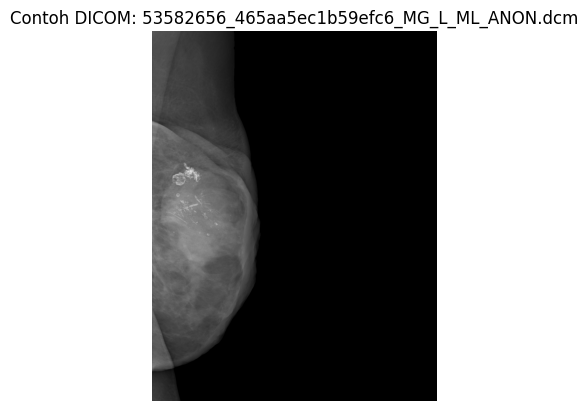

In [ ]:
#Visualize One Image from DICOM

# Temukan file DICOM pertama
sample_dcm_path = [f for f in all_files if f.endswith('.dcm')][0]

# Baca file DICOM
dcm = pydicom.dcmread(sample_dcm_path)

# Tampilkan gambar
plt.imshow(dcm.pixel_array, cmap='gray')
plt.title(f"Contoh DICOM: {os.path.basename(sample_dcm_path)}")
plt.axis('off')
plt.show()

In [ ]:
#Check Resolution of All Images

dcm_sizes = []

for path in all_files:
    if path.endswith(".dcm"):
        try:
            dcm = pydicom.dcmread(path)
            shape = dcm.pixel_array.shape
            dcm_sizes.append(shape)
        except Exception as e:
            print(f"Gagal baca: {path} — {e}")

# Buat DataFrame dan tampilkan statistik
df_dcm_sizes = pd.DataFrame(dcm_sizes, columns=["height", "width"])
print("Statistik ukuran gambar DICOM:")
print(df_dcm_sizes.describe())

Statistik ukuran gambar DICOM:
            height        width
count   410.000000   410.000000
mean   3635.931707  2872.819512
std     371.902918   377.806139
min    3328.000000  2560.000000
25%    3328.000000  2560.000000
50%    3328.000000  2560.000000
75%    4084.000000  3328.000000
max    4084.000000  3328.000000


In [ ]:
#Check Database

# Path ke file CSV
csv_path = "inbreast/INbreast Release 1.0/INbreast.csv"

# Baca file CSV, delimiter-nya semicolon
df = pd.read_csv(csv_path, delimiter=';')

# Tampilkan nama kolom
print("📄 Kolom yang tersedia:")
print(df.columns)

# Tampilkan beberapa baris awal
print("\n🔍 Sampel isi data:")
print(df.head())

# Hitung dan tampilkan distribusi Bi-Rads
print("\n📊 Distribusi Bi-Rads (severity level):")
birads_counts = df['Bi-Rads'].value_counts(dropna=True).sort_index()
print(birads_counts)

# Hitung total entri dengan nilai Bi-Rads
total_birads = birads_counts.sum()
print(f"\n📌 Total entri dengan Bi-Rads: {total_birads}")

# Hitung jumlah entri yang kosong
missing_birads = df['Bi-Rads'].isna().sum()
print(f"❗ Jumlah entri tanpa Bi-Rads (NaN): {missing_birads}")

📄 Kolom yang tersedia:
Index(['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date',
       'File Name', 'ACR', 'Bi-Rads'],
      dtype='object')

🔍 Sampel isi data:
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads  
0       1  
1       3  
2       1  
3       3  
4       5  

📊 Distribusi Bi-Rads (severity level):
Bi-Rads
1      67
2     220
3      23
4a     13
4b      8
4c     22
5      49
6       8
Name: count, dtype: int64

📌 Total entri dengan Bi-Rads: 410
❗ Jumlah entri tanpa Bi-Rads (NaN): 0


In [ ]:
#Cross Check Image and Database

# Path folder gambar
dicom_dir = "inbreast/INbreast Release 1.0/AllDICOMs"
all_dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith(".dcm")]

# Ambil Patient ID dari CSV
csv_ids = df['File Name'].astype(str).tolist()

# Cocokkan berdasarkan awalan
matched_files = []
for file in all_dicom_files:
    for pid in csv_ids:
        if file.startswith(pid + "_"):
            matched_files.append((pid, file))
            break

print(f"Jumlah file yang cocok berdasarkan Patient ID: {len(matched_files)} / {len(csv_ids)}")

Jumlah file yang cocok berdasarkan Patient ID: 410 / 410


# **DATA LOADING CMMD DATASET**

**CMMD CLINICAL DATA**

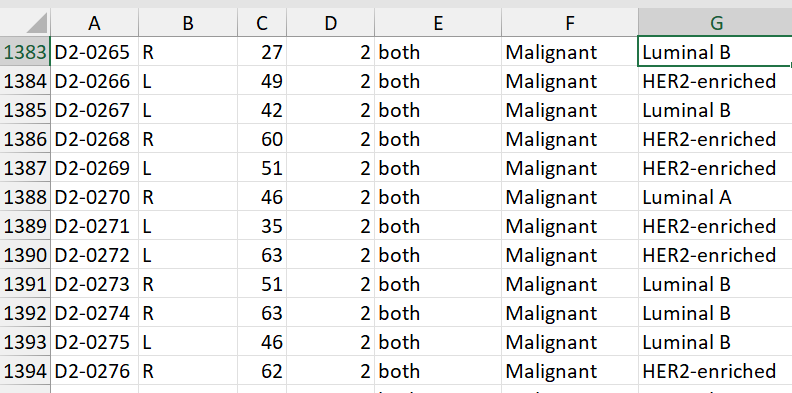

yang digunakan untuk menentukan molecular subtype adalah subset CMMD2

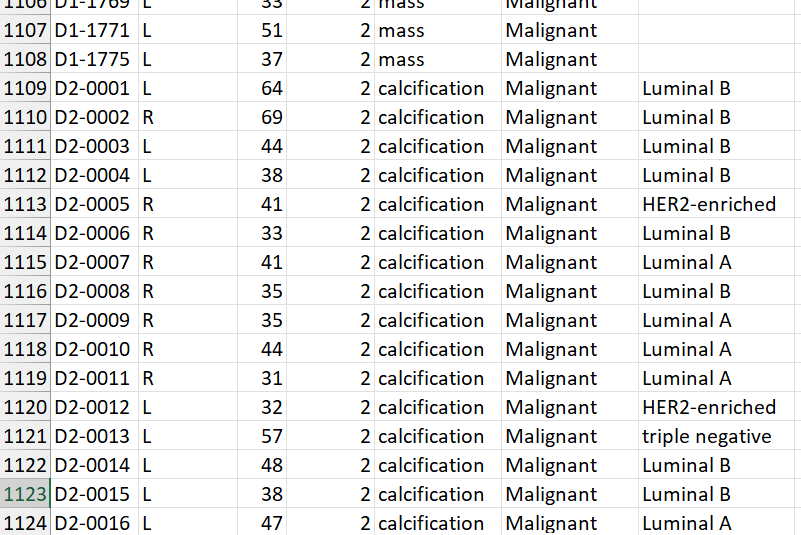

In [ ]:
# --- Setup ---
import gdown
import zipfile
import os
import pandas as pd

# Pastikan openpyxl terpasang (untuk .xlsx)
!pip install -q openpyxl

# ✅ Link Google Drive ZIP Dataset (View Only)
zip_url = "https://drive.google.com/uc?id=1uy9evH-11N2z4VjecPK_iVhVjrtqcdbx"
zip_output = "cmmd_dataset.zip"

# ✅ Link Google Sheets Clinical Data (Download sebagai .xlsx)
clinical_url = "https://docs.google.com/spreadsheets/d/1cM1JgKcROmTvG3ARKkVy1jZQWM1nQ-4p/export?format=xlsx"
clinical_output = "CMMD_clinicaldata_revision.xlsx"

# --- Download ZIP Dataset ---
if not os.path.exists(zip_output):
    gdown.download(zip_url, zip_output, quiet=False)
else:
    print("File ZIP sudah ada.")

# --- Download Clinical Data (.xlsx) ---
if not os.path.exists(clinical_output):
    gdown.download(clinical_url, clinical_output, quiet=False)
else:
    print("File clinical.xlsx sudah ada.")

# --- Ekstraksi ZIP Dataset ---
extract_path = "/content/cmmd_dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset berhasil diekstrak.")
else:
    print("Dataset sudah diekstrak sebelumnya.")


File ZIP sudah ada.


/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1cM1JgKcROmTvG3ARKkVy1jZQWM1nQ-4p/export?format=xlsx
To: /content/CMMD_clinicaldata_revision.xlsx
71.9kB [00:00, 272kB/s]

Dataset sudah diekstrak sebelumnya.


In [ ]:
# --- Tampilkan isi folder ---
print("Isi folder:", os.listdir(extract_path))

# --- Load Clinical Data dari Excel ---
try:
    df = pd.read_excel(clinical_output, engine='openpyxl')
    print("5 Baris pertama dari data klinis:")
    display(df.head())
except Exception as e:
    print("Gagal membaca file Excel:", e)

# --- Filter pasien dengan ID diawali 'D2-' (CMMD2) ---
if 'ID1' in df.columns:
    df_cmmd2 = df[df['ID1'].astype(str).str.startswith('D2-')].copy()
    print("5 Baris pertama dari data CMMD2:")
    display(df_cmmd2.head())

    # Simpan ke file Excel baru
    df_cmmd2.to_excel("CMMD2_only.xlsx", index=False)
    print("Data CMMD2_only.xlsx berhasil disimpan.")
else:
    print("Kolom 'ID1' tidak ditemukan dalam data klinis.")

Isi folder: ['manifest-1616439774456']
5 Baris pertama dari data klinis:


,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,Benign,NaN
1,D1-0002,L,40,2,calcification,Benign,NaN
2,D1-0003,L,39,2,calcification,Benign,NaN
3,D1-0004,L,41,2,calcification,Benign,NaN
4,D1-0005,R,42,2,calcification,Benign,NaN


5 Baris pertama dari data CMMD2:


,ID1,LeftRight,Age,number,abnormality,classification,subtype
1107,D2-0001,L,64,2,calcification,Malignant,Luminal B
1108,D2-0002,R,69,2,calcification,Malignant,Luminal B
1109,D2-0003,L,44,2,calcification,Malignant,Luminal B
1110,D2-0004,L,38,2,calcification,Malignant,Luminal B
1111,D2-0005,R,41,2,calcification,Malignant,HER2-enriched


Data CMMD2_only.xlsx berhasil disimpan.


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID1             1872 non-null   object
 1   LeftRight       1872 non-null   object
 2   Age             1872 non-null   int64 
 3   number          1872 non-null   int64 
 4   abnormality     1872 non-null   object
 5   classification  1872 non-null   object
 6   subtype         749 non-null    object
dtypes: int64(2), object(5)
memory usage: 102.5+ KB


None

Distribusi Target Kelas

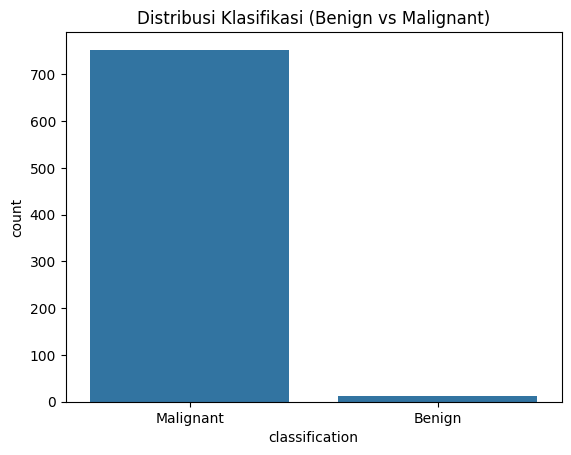

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='classification', data=df_cmmd2)
plt.title("Distribusi Klasifikasi (Benign vs Malignant)")
plt.show()


In [ ]:
df_cmmd2['classification'].value_counts(normalize=True)

,proportion
classification,
Malignant,0.984314
Benign,0.015686


Distribusi Sub-Type

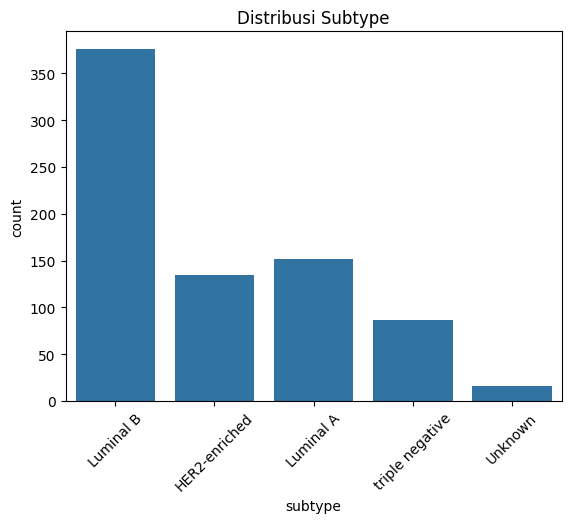

In [ ]:
sns.countplot(x='subtype', data=df_cmmd2)
plt.title("Distribusi Subtype")
plt.xticks(rotation=45)
plt.show()


Distribusi Usia Pasien

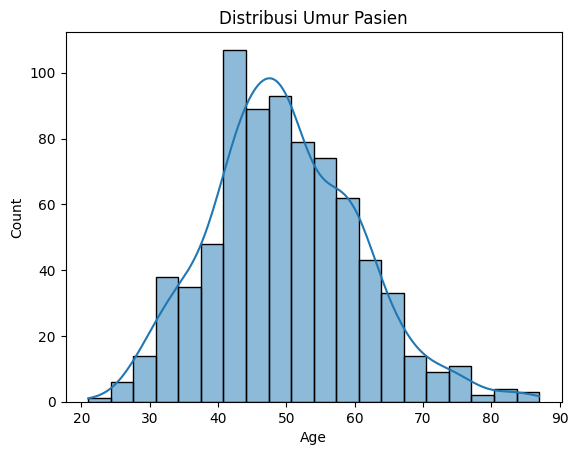

In [ ]:
sns.histplot(df_cmmd2['Age'], bins=20, kde=True)
plt.title("Distribusi Umur Pasien")
plt.xlabel("Age")
plt.show()


In [ ]:
df_cmmd2.isnull().sum()

,0
ID1,0
LeftRight,0
Age,0
number,0
abnormality,0
classification,0
subtype,0
